In [1]:
import pandas as pd
from typing import Any

from core.helpers import strategies
from collections import defaultdict
from core.talib_indicators import simulate_strategy
from core.trading import Trade

In [2]:
data = pd.read_csv("all_stocks_5yr.csv", index_col=0, parse_dates=True)

In [3]:
ticker = 'AAL'
stock_data = data[data['Name']==ticker]

In [4]:
# write a generator function that yields a slice of the dataframe
def get_trade_date(data:pd.DataFrame, days:int):
    for i in range(len(data)-days):
        yield data.index[i:i+days]

In [17]:
# turn into defaultdict
strategies_result = defaultdict(
    lambda: {
        'cash': 50_000,
        'total_portfolio_value': 0,
        'net_worth': 50_000,
        'holdings': defaultdict(
            lambda: {
                'trades': [
                    # {
                    #  'trade_time': None,
                    #  'trade_price': None,
                    #  'trade_quantity': None,
                    #  'trade_value': None,
                    #  'trade_action': None
                    # }
                ],  # List to store trade history
                'quantity': 0  # Current total quantity
            }
        ),
        'total_trades': 0,
        'successful_trades': 0,
        'score': 0,
        'profit_percentage': 0
    }
)

# {cash:int, 
# total_portfolio_value:int,
# holdings:{
#   ticker:dict{quantity:int, price:int}
#   }
# },
# total_trades:int, 
# successful_trades:int}

# for each day
# see if the strategy has holdings
# make a prediction on a company's price
# if buy, buy if you have cash
# if sell, sell if you have holdings
##  then check if you made profit
##  if profit, give +1 score to the strategy
# if hold, hold

trade_period = 120

trade_dates = get_trade_date(stock_data, trade_period)
for strategy in strategies:
    for trade_date in trade_dates:
        trade_data = stock_data.loc[trade_date]
        current_price = trade_data['close'].iloc[-1]
        
        account_cash = strategies_result[strategy.__name__]['cash']
        portfolio_qty = strategies_result[strategy.__name__]['holdings'][ticker]['quantity']
        total_portfolio_value = strategies_result[strategy.__name__]['total_portfolio_value']

        action = strategy(ticker, trade_data)
        trade = Trade(strategy.__name__, 
                    ticker, 
                    action, 
                    current_price, 
                    account_cash, 
                    portfolio_qty, 
                    total_portfolio_value)

        updated_account_cash, updated_portfolio_qty, updated_total_portfolio_value, updated_net_worth = trade.execute_trade()

        if trade.trade_quantity > 0:
            trade_record = {
                        'timestamp': trade_date.max(),
                        'quantity': trade.trade_quantity if trade.action == 'buy' else -trade.trade_quantity,
                        'price': trade.current_price,
                        'action': trade.action,
                        'value': trade.trade_quantity * trade.current_price,
                        'updated_account_cash':updated_account_cash, 
                        'updated_portfolio_qty':updated_portfolio_qty, 
                        'updated_total_portfolio_value':updated_total_portfolio_value, 
                        'updated_net_worth':updated_net_worth
                    }
            
            strategies_result[strategy.__name__]['holdings'][ticker]['trades'].append(trade_record)
        # else:
        #     trade_record = {
        #                 'timestamp': trade_date.max(),
        #                 'quantity': 0,
        #                 'price': trade.current_price,
        #                 'action': trade.action,
        #                 'value': 0
        #             }
        #     strategies_result[strategy.__name__]['holdings'][ticker]['trades'].append(trade_record)


        # if updated_total_portfolio_value > total_portfolio_value:
        #     strategies_result[strategy.__name__]['successful_trades'] += 1
        
        # record the trade outcomes
        strategies_result[strategy.__name__]['total_trades'] += 1
        strategies_result[strategy.__name__]['holdings'][ticker]['quantity'] = updated_portfolio_qty
        strategies_result[strategy.__name__]['cash'] = updated_account_cash
        strategies_result[strategy.__name__]['total_portfolio_value'] = updated_total_portfolio_value
        strategies_result[strategy.__name__]['net_worth'] = updated_net_worth
    
    # # calculate the score for the strategy
    # strategies_result[strategy.__name__]['score'] = strategies_result[strategy.__name__]['successful_trades'] / strategies_result[strategy.__name__]['total_trades']

    # # calculate the profit percentage for the strategy
    # strategies_result[strategy.__name__]['profit_percentage'] = (strategies_result[strategy.__name__]['total_portfolio_value'] - strategies_result[strategy.__name__]['cash']) / strategies_result[strategy.__name__]['cash']


# strategy has cash, holdings (dict[ticker:list[dict[quantity, price]]]), total_trades, successful trades

In [18]:
strategy_name = 'BBANDS_indicator'
# strategy_name2 = 'BBANDS_indicator'

sell_timestamps = [trade['timestamp'] for trade in strategies_result[strategy_name]['holdings']['AAL']['trades'] if trade['action'] == 'sell']
sell_amounts = [abs(trade['value']) / 100 for trade in strategies_result[strategy_name]['holdings']['AAL']['trades'] if trade['action'] == 'sell']


buy_timestamps = [trade['timestamp'] for trade in strategies_result[strategy_name]['holdings']['AAL']['trades'] if trade['action'] == 'buy']
buy_amounts = [abs(trade['value']) / 100 for trade in strategies_result[strategy_name]['holdings']['AAL']['trades'] if trade['action'] == 'buy']

hold_timestamps = [trade['timestamp'] for trade in strategies_result[strategy_name]['holdings']['AAL']['trades'] if trade['action'] == 'hold']


In [19]:
# plot sell and buy timestamps on the stock data
import matplotlib.pyplot as plt

In [32]:
strategies_result

defaultdict(<function __main__.<lambda>()>,
            {'BBANDS_indicator': {'cash': np.float64(92315.85589999995),
              'total_portfolio_value': np.float64(1177.1399999999994),
              'net_worth': np.float64(93492.99589999995),
              'holdings': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                          {'AAL': {'trades': [{'timestamp': Timestamp('2013-08-13 00:00:00'),
                              'quantity': 611,
                              'price': np.float64(16.36),
                              'action': 'buy',
                              'value': np.float64(9995.96),
                              'updated_account_cash': np.float64(40004.04),
                              'updated_portfolio_qty': 611,
                              'updated_total_portfolio_value': np.float64(9995.96),
                              'updated_net_worth': np.float64(50000.0)},
                             {'timestamp': Timestamp('2013-08-14 00

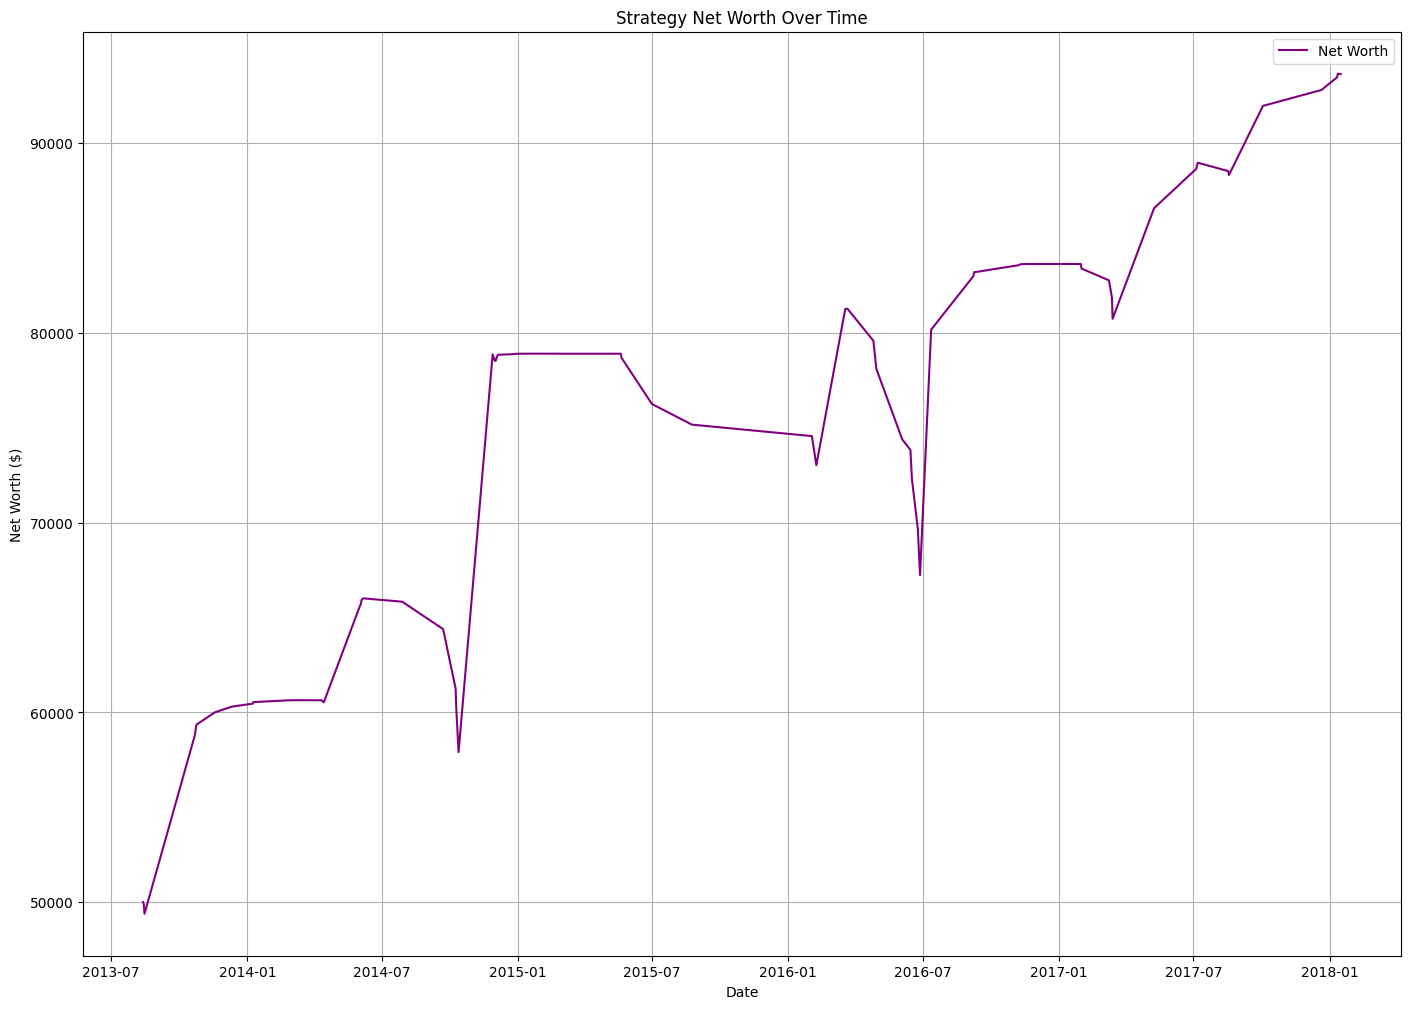

In [22]:
# Create a list of all trades sorted by timestamp
all_trades = strategies_result[strategy_name]['holdings']['AAL']['trades']
all_trades_sorted = sorted(all_trades, key=lambda x: x['timestamp'])

# Calculate cumulative net worth after each trade
net_worth_history = [trade['updated_net_worth'] for trade in all_trades]
timestamps = [trade['timestamp'] for trade in all_trades]

# Plot net worth over time
plt.figure(figsize=(17, 12))
plt.plot(timestamps, net_worth_history, color='purple', label='Net Worth')
plt.title('Strategy Net Worth Over Time')
plt.xlabel('Date')
plt.ylabel('Net Worth ($)')
plt.legend()
plt.grid(True)
plt.show()



In [24]:
# count successful trades where net worth increased
successful_trades:int = 0
total_trades_count:int = 0
previous_net_worth:int = 50_000

for trade in all_trades:
    if trade['updated_net_worth'] > previous_net_worth:
        successful_trades+=1
    total_trades_count+=1

In [26]:
successful_trades / total_trades_count
# 96% of trades resulted in increased net worth

0.9629629629629629

In [27]:
# now check how much profit the buy-and-hold strategy brings
import math

initial_price = stock_data['close'].iloc[0] 
initial_buy_quantity = math.floor(50_000 / initial_price)

final_price = stock_data['close'].iloc[-1]
final_net_worth = final_price * initial_buy_quantity

In [28]:
final_net_worth

np.float64(174194.6)

In [29]:
# this baseline purchased stocks with all of its cash. 
# the indicator, however, only used part of its cash. how much of its cash did it really use to buy stocks?
portfolio_value_history = [trade['updated_total_portfolio_value'] for trade in all_trades]

portfolio_ratio = [asset_value / total_net_worth for asset_value, total_net_worth in zip(portfolio_value_history, net_worth_history)]

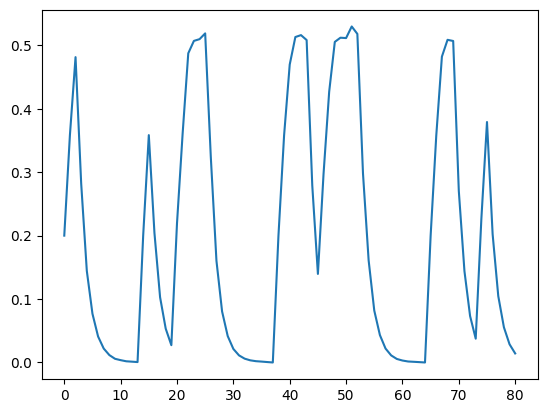

In [31]:
plt.plot(range(len(portfolio_ratio)), portfolio_ratio)
# the ratio of total net worth invested in stocks did not exceed 50%
# thus a fairer baseline would only have 50% of initial cash.
# besides, this stock had an upward trend 
# which nobody could predict
# so buy-and-hold is risky
# while the BBands indicator attempts to sells before prices fall
# one limitation is that it also buys when prices fall 
# below the lower line, so it does not perform well
# in market breakouts
# https://www.investopedia.com/articles/trading/08/trading-breakouts.asp
# it is probably possible to combine bbands with another indicator that 
# covers its weakness

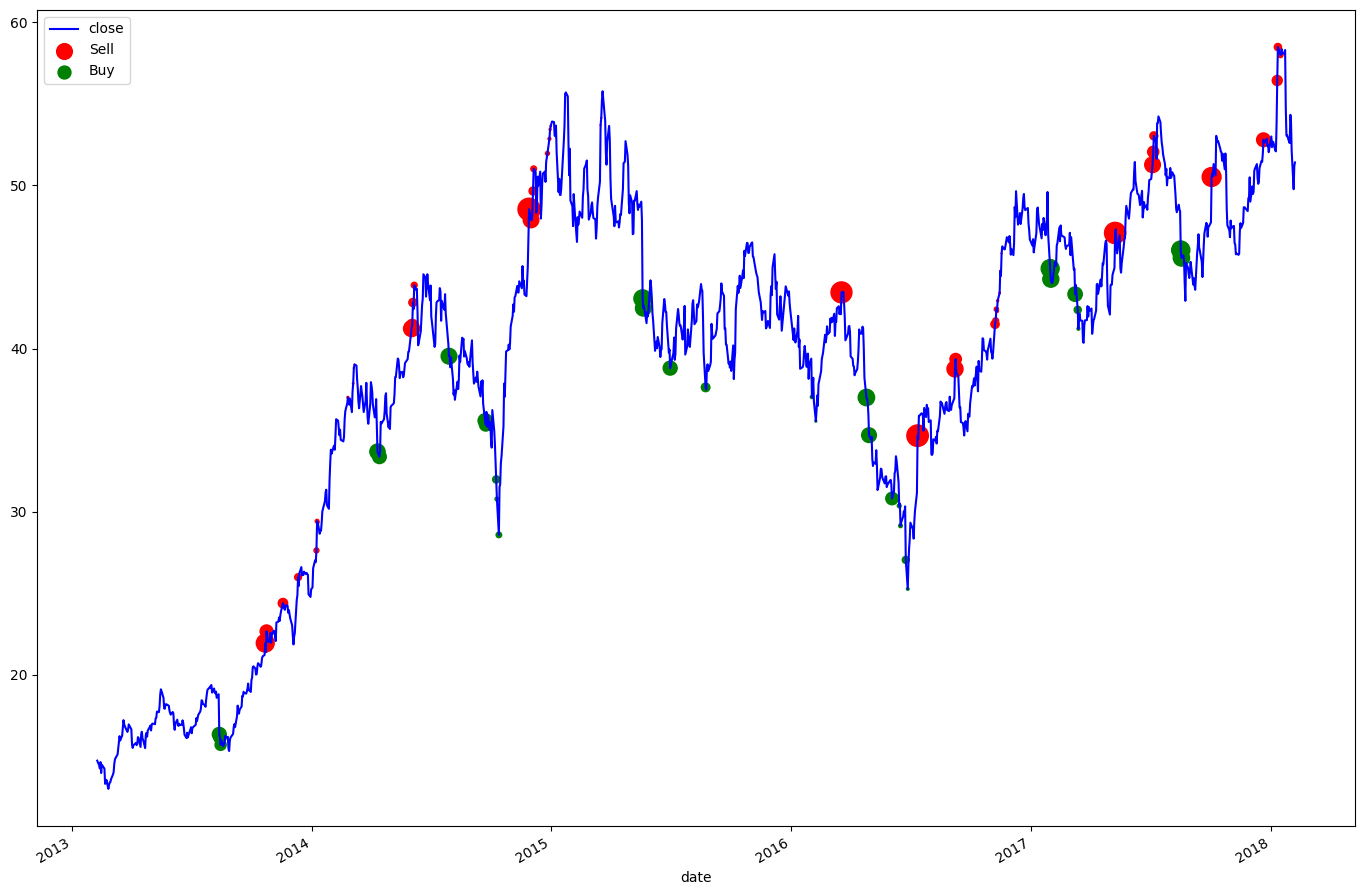

In [23]:


plt.figure(figsize=(17, 12))

stock_data['close'].plot(color='blue')
plt.scatter(sell_timestamps, stock_data.loc[sell_timestamps]['close'], color='red', label='Sell', s=sell_amounts)
plt.scatter(buy_timestamps, stock_data.loc[buy_timestamps]['close'], color='green', label='Buy', s=buy_amounts)
# plt.scatter(hold_timestamps, stock_data.loc[hold_timestamps]['close'], color='blue', label='Hold')
plt.legend()
plt.show()

The performance of the BBands strategy is not good on its own.
But several indicators can be ranked and combined to make better decisions. 


Potentially, several indicators can be combined to make a new indicator that models different market conditions.